In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, moyal, wasserstein_distance


In [2]:

# Data generation
size = 1000000
unif_ditr = uniform(loc=2, scale=1)
random_pt = unif_ditr.rvs(size=size, random_state=42)
landau_distr = moyal(loc=1, scale=0.2)
random_smearing = landau_distr.rvs(size=size, random_state=42)
smeared_pt = np.multiply(random_pt, random_smearing)


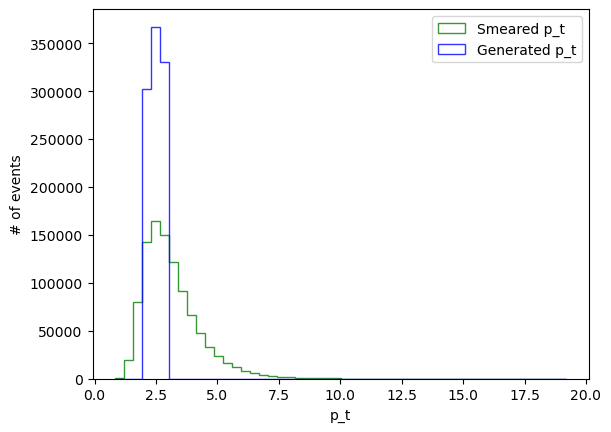

In [3]:

plt.hist([random_pt, smeared_pt], bins=50, histtype='step', color=['blue', 'green'], alpha=0.8,
         label=['Generated p_t', 'Smeared p_t'], density=False)
plt.xlabel('p_t')
plt.ylabel('# of events')
plt.legend(loc='best')
plt.show()


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)  # Output scalare: stima della distanza di Wasserstein
        )

    def forward(self, x):
        return self.model(x)

In [5]:

# Wasserstein loss
def wasserstein_loss(y_pred, y_true):
    return torch.mean(y_true * y_pred)

# Gradient Penalty
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.size(0)
    
    # Interpoliamo tra i due set di dati
    alpha = torch.rand(batch_size, 1).to(real_data.device)
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated.requires_grad_(True)

    # Calcoliamo l'output del critico
    critic_output = critic(interpolated)

    # Calcoliamo il gradiente rispetto agli input interpolati
    gradients = autograd.grad(
        outputs=critic_output, 
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_output),
        create_graph=True, 
        retain_graph=True
    )[0]

    # Penalità sul gradiente: deve essere vicino a 1
    grad_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    gp = ((grad_norm - 1) ** 2).mean()
    return gp


In [6]:
# Iperparametri
latent_dim = 8
data_dim = 1  # Supponiamo dati bidimensionali (modificare se necessario)
epochs = 2000
batch_size = 32
lr = 0.0001
lambda_gp = 10  # Peso della penalità sul gradiente
n_critic = 5  # Numero di aggiornamenti del critico prima di aggiornare il generatore

# Modelli
generator = Generator(latent_dim, data_dim)
critic = Critic(data_dim)

# Ottimizzatori
g_optim = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
d_optim = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))
smeared_pt_tensor = torch.tensor(smeared_pt, dtype=torch.float32)


In [7]:
import time
# Training Loop
generator_losses = []
critic_losses = []
wd_metrics = []
mse_metrics = []
mae_metrics = []
total_weight_update_time = 0.0
for epoch in range(epochs):
    start_update = time.perf_counter()
    for _ in range(n_critic):
        noise = torch.randn(batch_size, latent_dim)
        real_data = smeared_pt_tensor[_:_ + batch_size].unsqueeze(1)
        fake_data = generator(noise).detach()

        # Loss critico
        real_loss = torch.mean(critic(real_data))
        fake_loss = torch.mean(critic(fake_data))
        gp = gradient_penalty(critic, real_data, fake_data)
        critic_loss = -(real_loss - fake_loss) + lambda_gp * gp

        d_optim.zero_grad()
        critic_loss.backward()
        d_optim.step()
        critic_losses.append(critic_loss.item())

    # Aggiornamento del generatore
    noise = torch.randn(batch_size, latent_dim)
    fake_data = generator(noise)
    generator_loss = -torch.mean(critic(fake_data))

    g_optim.zero_grad()
    generator_loss.backward()
    g_optim.step()
    generator_losses.append(generator_loss.item())
    end_update = time.perf_counter()
    total_weight_update_time += (end_update - start_update)
    # Switch to evaluation mode (optional)
    generator.eval()
    with torch.no_grad():
        # Generate 1000 fake samples from the generator
        noise_eval = torch.randn(1000, latent_dim)
        fake_samples = generator(noise_eval)
        # Assume generator output is shaped (1000, 1) – convert to numpy and flatten
        fake_samples_np = fake_samples.detach().cpu().numpy().flatten()
    # Randomly select 1000 real samples from your real data tensor.
    idx = np.random.choice(smeared_pt_tensor.size(0), 1000, replace=False)
    real_samples = smeared_pt_tensor[idx].unsqueeze(1)  # Ensure shape (1000, 1)
    real_samples_np = real_samples.detach().cpu().numpy().flatten()
    # Sort both arrays for a quantile-based comparison
    #fake_sorted = np.sort(fake_samples_np)
    #real_sorted = np.sort(real_samples_np)
    # Compute metrics
    wd = wasserstein_distance(real_samples_np, fake_samples_np)
    mse_metric = np.mean((real_samples_np - fake_samples_np )** 2)
    mae_metric = np.mean(np.abs(real_samples_np - fake_samples_np ))
    wd_metrics.append(wd)
    mse_metrics.append(mse_metric)
    mae_metrics.append(mae_metric)
    

    # Return to training mode
    generator.train()


    # Stampa dei progressi
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Critic Loss: {critic_loss.item():.4f}, Generator Loss: {generator_loss.item():.4f}")
        print(f"Epoch {epoch}: Critic Loss: {critic_loss.item():.4f}, "
              f"Generator Loss: {generator_loss.item():.4f}, "
              f"WD: {wd:.4f}, MSE: {mse_metric:.4f}, MAE: {mae_metric:.4f}")


Epoch 0: Critic Loss: 9.4588, Generator Loss: 0.3633
Epoch 0: Critic Loss: 9.4588, Generator Loss: 0.3633, WD: 3.2368, MSE: 11.8263, MAE: 3.2368
Epoch 100: Critic Loss: 8.8084, Generator Loss: 0.4205
Epoch 100: Critic Loss: 8.8084, Generator Loss: 0.4205, WD: 3.1760, MSE: 11.4271, MAE: 3.1760
Epoch 200: Critic Loss: 7.0232, Generator Loss: 0.5002
Epoch 200: Critic Loss: 7.0232, Generator Loss: 0.5002, WD: 3.0451, MSE: 10.5500, MAE: 3.0451
Epoch 300: Critic Loss: 5.3541, Generator Loss: 0.5981
Epoch 300: Critic Loss: 5.3541, Generator Loss: 0.5981, WD: 2.9548, MSE: 9.8973, MAE: 2.9548
Epoch 400: Critic Loss: 3.0123, Generator Loss: 0.7065
Epoch 400: Critic Loss: 3.0123, Generator Loss: 0.7065, WD: 2.9528, MSE: 10.1094, MAE: 2.9528
Epoch 500: Critic Loss: 1.0693, Generator Loss: 0.8035
Epoch 500: Critic Loss: 1.0693, Generator Loss: 0.8035, WD: 2.8615, MSE: 9.6308, MAE: 2.8615
Epoch 600: Critic Loss: -0.3881, Generator Loss: 0.8976
Epoch 600: Critic Loss: -0.3881, Generator Loss: 0.8976,

In [8]:
print(f"Training time: {total_weight_update_time:.2f}s for {epochs} epochs")

Training time: 6.55s for 2000 epochs


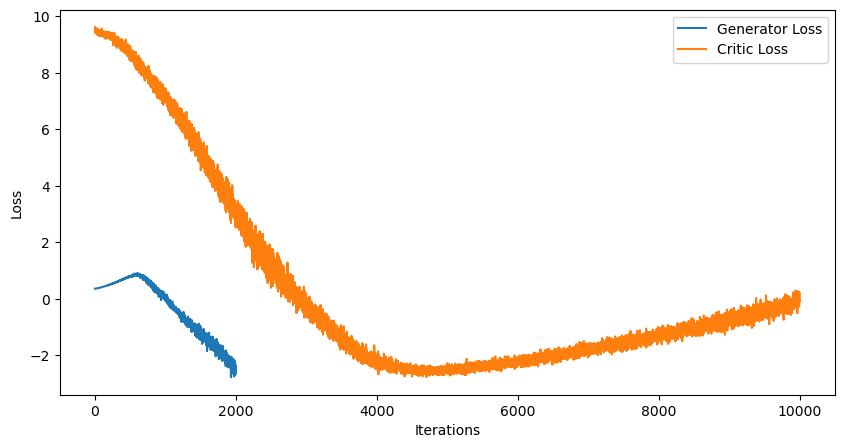

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss")
plt.plot(critic_losses, label="Critic Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

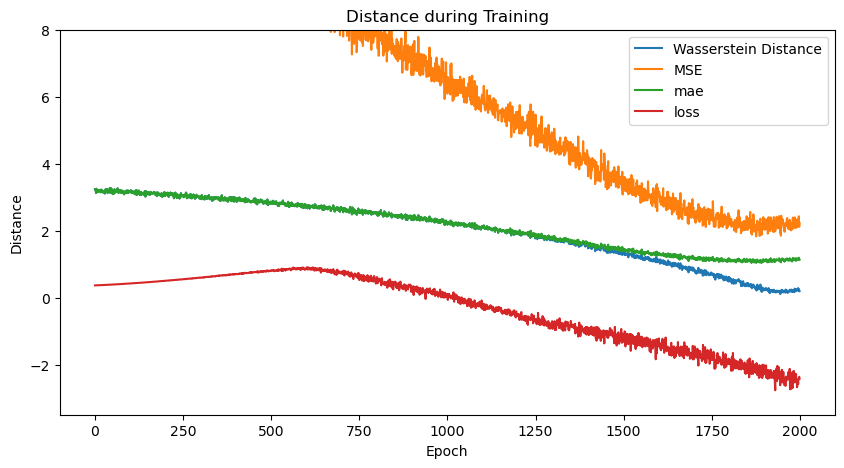

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(wd_metrics, label="Wasserstein Distance")
plt.plot(mse_metrics, label="MSE")
plt.plot(mae_metrics, label="mae")
plt.plot(generator_losses, label="loss")
plt.xlabel("Epoch")
plt.ylabel("Distance")
plt.title("Distance during Training")
plt.ylim(-3.5,8)
plt.legend()
plt.show()

In [11]:
generator.eval()
with torch.no_grad():
    sample_size = 10000
    start=time.perf_counter()
    noise = torch.randn(sample_size, latent_dim)

    generated_samples = generator(noise).numpy()
    stop=time.perf_counter()
    GeneratorTimer=(stop-start)/sample_size

In [12]:
print(f"Time for generating a data: {GeneratorTimer:.2e}s")

Time for generating a data: 7.69e-06s


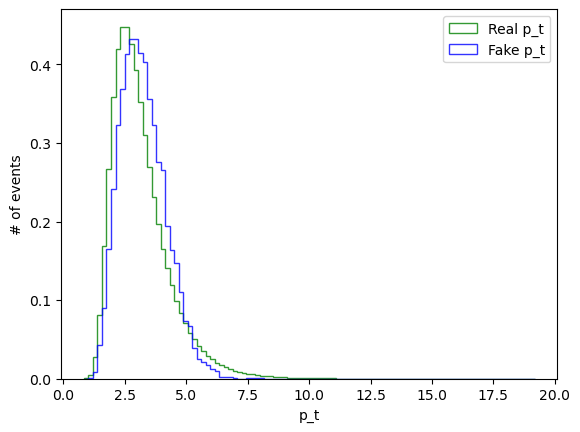

In [13]:

plt.hist([generated_samples[:, 0], smeared_pt], bins=100, histtype='step', color=['blue', 'green'], alpha=0.8,
         label=['Fake p_t', 'Real p_t'], density=True)
plt.xlabel('p_t')
plt.ylabel('# of events')
plt.legend(loc='best')
plt.savefig('gen_vs_fake.pdf')

In [14]:
def plot_loss(loss, log_dir=".", name="", sep=False):
    """Plot the traings curve"""
    fig, ax1 = plt.subplots(1, figsize=(10, 4))
    epoch = np.arange(len(loss))
    loss = np.array(loss)
    if(sep == True):
        #plt.plot(epoch, loss[:, 1] + loss[:, 2], color='green', label=r'Wasserstein Tot', linestyle='dashed')
        plt.plot(epoch, loss[:, 1], color='red', label=r'Wasserstein Gen', linestyle='dashed')
        plt.plot(epoch, loss[:, 2], color='blue', label=r'Wasserstein Real', linestyle='dashed')
    else:
        try:
            plt.plot(epoch, loss[:, 0], color='red', markersize=12, label=r'Total')
            plt.plot(epoch, loss[:, 1] + loss[:, 2], color='green', label=r'Wasserstein', linestyle='dashed')
            plt.plot(epoch, loss[:, 3], color='royalblue', markersize=12, label=r'GradientPenalty', linestyle='dashed')
            plt.plot([0, loss.shape[0]], [0, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
        except:
            plt.plot([0, loss.shape[0]], [0, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
            plt.plot(epoch, loss[:], color='red', markersize=12, label=r'Total')
    
    plt.legend(loc='upper right', prop={'size': 10})
    ax1.set_xlabel(r'Iterations')
    ax1.set_ylabel(r'Loss')
    ax1.set_ylim(np.min(loss)-0.5, 2)
    fig.savefig(log_dir + '/%s_Loss.png' % name, dpi=120)

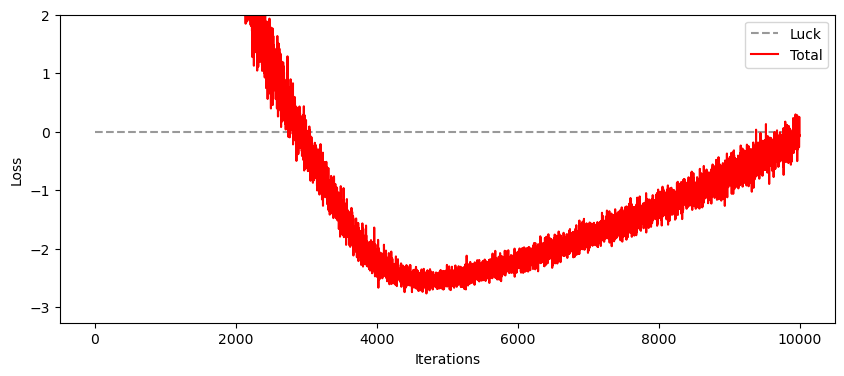

In [15]:
plot_loss(critic_losses, name="critic")

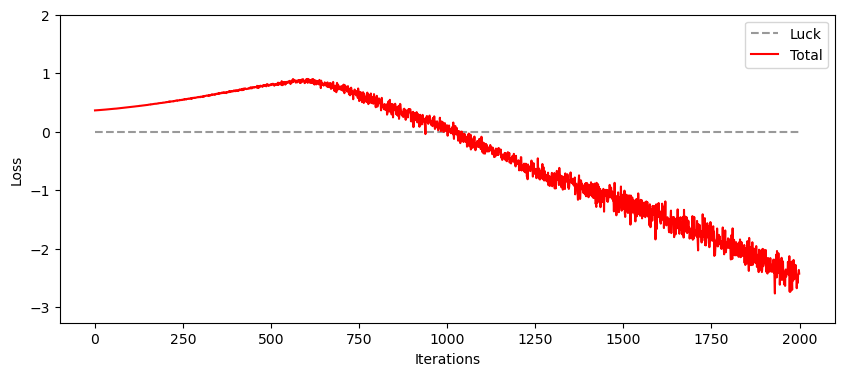

In [16]:
plot_loss(generator_losses, name='generator')